![./img/sp_tiny.png](./img/sp_tiny.png)
<h1><center>Accent Detection: <br>
Signal Processing  + CNN</center></h1>
<h3><center>Part 4.2: Signal Processing + CNN - Languages Set 2</center></h3>
<center>Group 2: Katerina Bosko and Victor Wilm
<center>Northeastern University, CS6140

In [1]:
import os
from glob import glob
from ipywidgets import IntProgress
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seed value for experiment reproducibility
seed = 36
tf.random.set_seed(seed)
np.random.seed(seed)

2022-12-14 17:30:19.724729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In this notebook, we perform CNN on Mel Spectograms produced by Signal Processing. The approach is based on the paper by Michailava et al (2022) mentioned in the references. 

# 1. Signal Processing

## Notes on parameters

### Sample rate
Sample rate = 22050 Hz was not changed. This is standard in librosa library.

### STFT window size
https://librosa.org/doc/latest/generated/librosa.stft.html#librosa.stft

n_fft = length of the windowed signal after padding with zeros. The number of rows in the STFT matrix D is (1 + n_fft/2). **The default value, n_fft=2048 samples**, corresponds to a physical duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the default sample rate in librosa. This value is well adapted for **music signals**. However, in **speech processing, the recommended value is 512**, corresponding to 23 milliseconds at a sample rate of 22050 Hz. In any case, we recommend setting n_fft to a power of two for optimizing the speed of the fast Fourier transform (FFT) algorithm.

Based on above description, n_fft=512 was chosen, which is equivalent to 512/22050=0.023 or 23 ms

### Hop length
Hop length was chosen as window_size // 2 = 512//2 = 256, which is equivalent to 256//22050=0.011 or 11 ms
Such a hop length ensures that there is a signal overlap when extracting STFT features.

### Frame size
Frame size was chosen as 75 frames, which is rather small such that we can extract phonemes. We experimented with a larger number of frame size and it didn't result into higher than 30-40% accuracy scores.


## Notes on processing steps
Preprocessing steps are as follows:

1. Balancing the dataset
2. Signal Processing with the chosen method
3. Normalization at the level of each frequency
4. Segmentation based on the frame size

We experimented with different order of processing steps. For instance, 
1. Segmentation
2. Signal processing
3. Normalization 

or:
1. Normalization
2. Segmentation
3. Signal processing


these approaches also failed (the accuracy scores were not high enough).

In [2]:
def get_max_num_files(dataset_path):
    # get links to audio files
    audio_files = glob(f"{dataset_path}/*/*.wav")
    # note .DS_store needs to be removed
    if '.DS_Store' in os.listdir(dataset_path):
        os.remove(f'{dataset_path}/.DS_Store')

    languages = os.listdir(dataset_path)
    audio_files_by_lang = {}
    for lang in languages:
        audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")

    num_files_per_lang = [len(audio_files_by_lang[lang]) for lang in audio_files_by_lang]
    return np.array(num_files_per_lang).min()

In [3]:
def limit_num_audio_files_per_lang(dataset_path):
    max_num_files = get_max_num_files(dataset_path)
    if '.DS_Store' in os.listdir(dataset_path):
        os.remove(f'{dataset_path}/.DS_Store')

    languages = os.listdir(dataset_path)
    lang_mapping = {l: i for i, l in enumerate(languages)}

    audio_files_by_lang = {}
    # limit to MAX_NUM_FILES for each lang
    for lang in languages:
        audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")[:max_num_files]
        print(f"num audio files for {lang.upper()}: {len(audio_files_by_lang[lang])}")

    audio_files = [file for lang_files in audio_files_by_lang.values() for file in lang_files]
    return audio_files

In [4]:
def extract_features_melspectogram(dataset_path, sample_rate=22050, n_fft=512, frame_size=75, n_mels=64):
    hop_length = n_fft // 2
    win_len = n_fft

    # get languages mapping for y
    languages = os.listdir(dataset_path)
    lang_mapping = {l: i for i, l in enumerate(languages)}

    # PROCESSING STEPS
    # 1. Balancing the dataset
    audio_files = limit_num_audio_files_per_lang(dataset_path)
    
    # instantiate the progress bar
    f = IntProgress(min=0, max=len(audio_files)) 
    display(f) # display the bar


    X = []
    y = []
    for file in audio_files:
        f.value += 1
        # get file's language
        lang_pos = len(dataset_path.split("/"))
        lang = file.split("/")[lang_pos]
        
        # 2. Signal processing
        signal, _ = librosa.load(file, sr=sample_rate)
        # mel_sp shape (n_mels, len(signal)/hop_length), e.g. (64, 1852)
        mel_sp = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=n_mels, hop_length=hop_length,
                                           win_length=win_len, power=1.0)        
        # 3. Normalization along N_MEL axis
        mel_sp_norm_vector = []
        for i in range(mel_sp.shape[0]):
            mel_sp_norm = StandardScaler().fit_transform(mel_sp[i, :].reshape(-1, 1)).reshape(-1)
            mel_sp_norm_vector.append(mel_sp_norm)

        features = np.vstack(mel_sp_norm_vector)
        
        # 4. Segmentation based on frame size
        segments = []
        labels = []
        new_signal_len = features.shape[1]
        for frame_start in range(0, int(new_signal_len / frame_size)):
            # features_cut.shape = (n_mels, frame_size), e.g. (64, 75)
            features_cut = features[:, frame_start * frame_size:(frame_start + 1) * frame_size]
            # num segments = stft_signal_len // frame_size, e.g. 1852 // 75 = 24
            segments.append(features_cut)
            labels.append(lang_mapping[lang])
        # X_per_file.shape = (n_mels * num_segments, frame_size), e.g. (64 * 24, 75)=(1536, 75) 
        X_per_file = np.vstack(segments)
        y_per_file = np.vstack(labels)
        # X.shape = (sum(n_mels * num_segments per file), frame_size), e.g. ((1536+1856...), 75)
        X.append(X_per_file)
        # y is same as total number of segments
        y.append(y_per_file)
    
    # transform X list into np.array (doesn't change shape)
    X = np.vstack(X)
    y = np.vstack(y)
    
    # reshape into (total_num_segments, n_mels, frame_size)
    total_num_segments = y.shape[0]
    X = X.reshape(total_num_segments, -1, frame_size)
    print(X.shape, y.shape)
    return X, y 

# Languages set 2: English, Russian, Arabic, French

In [5]:
dataset_path = "./data/lang_set_2"
X, y = extract_features_melspectogram(dataset_path)

num audio files for RUSSIAN: 81
num audio files for ENGLISH: 81
num audio files for FRENCH: 81
num audio files for ARABIC: 81


IntProgress(value=0, max=324)

(10683, 64, 75) (10683, 1)


In [6]:
X.shape, y.shape

((10683, 64, 75), (10683, 1))

In [7]:
# data = {"x": X.tolist(), "y": y.tolist(), "x_shape": X.shape, "y_shape": y.shape}
# JSON_PATH = "./data/stft_normalized_segmentedafter_oldlang.json"

# with open(JSON_PATH, "w") as fp:
#     json.dump(data, fp, indent=4)

## Splitting into Train, Validation, Test

In [8]:
def prepare_datasets(X, y, test_size, validation_size):
    """
    Loads data and splits it into train, validation and test sets
    """

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=1234)

    # add an axis to input sets (aka channel for image)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(X, y, 0.25, 0.2)

In [10]:
# shape (`batch_size`, `height`, `width`, `channels`)
X_train.shape, X_val.shape, X_test.shape

((6409, 64, 75, 1), (1603, 64, 75, 1), (2671, 64, 75, 1))

# 2. CNN

In [11]:
def plot_history(history):
    """
    Plots accuracy/loss for training/validation set as a function of the epochs
    """

    fig, ax = plt.subplots(figsize=(12,6), ncols=2)

    # accuracy sublpot
    ax[0].plot(history.history["accuracy"], label="train accuracy")
    ax[0].plot(history.history["val_accuracy"], label="val accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[0].set_ylim([0,1])
    ax[0].set_title("Accuracy")

    # loss sublpot
    ax[1].plot(history.history["loss"], label="train error")
    ax[1].plot(history.history["val_loss"], label="val error")
    ax[1].set_ylabel("Error")
    ax[1].set_xlabel("Epoch")
    ax[1].set_title("Loss")
    plt.legend()

    plt.show()

In [12]:
def plot_confusion_matrix(model, X_test, languages):
    """
    Plots confusion matrix for model prediction on test 
    """

    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred, axis=1)

    y_true = y_test

    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=languages,
                yticklabels=languages,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [13]:
input_shape = X_train.shape[1:]
input_shape

(64, 75, 1)

In [14]:
NUM_LABELS = 4

tf.keras.backend.clear_session()
model = Sequential()

# 1st conv layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

# 2nd conv layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.1))

# flatten output and feed it into dense layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

# output layer
model.add(Dense(NUM_LABELS, activation='softmax'))

2022-12-14 17:34:25.341324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# default values: lr=0.001 beta_1=0.9 beta_2=0.999 as in paper
optimiser = Adam()
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 73, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 73, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 37, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 35, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 35, 64)       256       
 hNormalization)                                                 
                                                        

In [16]:
NUM_EPOCHS = 120
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS)


Epoch 1/120
101/101 [==============================] - 25s 243ms/step - loss: 2.1037 - accuracy: 0.3077 - val_loss: 11.3772 - val_accuracy: 0.2870
Epoch 2/120
101/101 [==============================] - 24s 240ms/step - loss: 1.3018 - accuracy: 0.3394 - val_loss: 17.7864 - val_accuracy: 0.3163
Epoch 3/120
101/101 [==============================] - 24s 234ms/step - loss: 1.2507 - accuracy: 0.4041 - val_loss: 12.5584 - val_accuracy: 0.2901
Epoch 4/120
101/101 [==============================] - 24s 233ms/step - loss: 1.2108 - accuracy: 0.4322 - val_loss: 6.2493 - val_accuracy: 0.2938
Epoch 5/120
101/101 [==============================] - 24s 240ms/step - loss: 1.1574 - accuracy: 0.4494 - val_loss: 2.2375 - val_accuracy: 0.3843
Epoch 6/120
101/101 [==============================] - 24s 241ms/step - loss: 1.1173 - accuracy: 0.4931 - val_loss: 1.4405 - val_accuracy: 0.4485
Epoch 7/120
101/101 [==============================] - 24s 241ms/step - loss: 1.0616 - accuracy: 0.5216 - val_loss: 1.619

Epoch 57/120
101/101 [==============================] - 25s 251ms/step - loss: 0.1243 - accuracy: 0.9501 - val_loss: 1.3440 - val_accuracy: 0.6906
Epoch 58/120
101/101 [==============================] - 26s 256ms/step - loss: 0.1143 - accuracy: 0.9554 - val_loss: 1.1810 - val_accuracy: 0.7193
Epoch 59/120
101/101 [==============================] - 25s 248ms/step - loss: 0.1214 - accuracy: 0.9519 - val_loss: 1.3186 - val_accuracy: 0.7162
Epoch 60/120
101/101 [==============================] - 25s 249ms/step - loss: 0.1171 - accuracy: 0.9551 - val_loss: 1.1890 - val_accuracy: 0.7305
Epoch 61/120
101/101 [==============================] - 25s 250ms/step - loss: 0.1188 - accuracy: 0.9524 - val_loss: 1.1865 - val_accuracy: 0.7455
Epoch 62/120
101/101 [==============================] - 25s 242ms/step - loss: 0.1190 - accuracy: 0.9535 - val_loss: 1.6116 - val_accuracy: 0.6999
Epoch 63/120
101/101 [==============================] - 25s 248ms/step - loss: 0.1247 - accuracy: 0.9546 - val_loss: 1

101/101 [==============================] - 23s 229ms/step - loss: 0.0704 - accuracy: 0.9735 - val_loss: 1.2755 - val_accuracy: 0.7480
Epoch 113/120
101/101 [==============================] - 24s 236ms/step - loss: 0.0728 - accuracy: 0.9741 - val_loss: 1.6966 - val_accuracy: 0.6737
Epoch 114/120
101/101 [==============================] - 24s 235ms/step - loss: 0.0746 - accuracy: 0.9764 - val_loss: 1.5782 - val_accuracy: 0.7062
Epoch 115/120
101/101 [==============================] - 24s 239ms/step - loss: 0.0907 - accuracy: 0.9691 - val_loss: 1.8257 - val_accuracy: 0.7006
Epoch 116/120
101/101 [==============================] - 25s 243ms/step - loss: 0.0794 - accuracy: 0.9729 - val_loss: 1.1490 - val_accuracy: 0.7623
Epoch 117/120
101/101 [==============================] - 24s 233ms/step - loss: 0.0858 - accuracy: 0.9719 - val_loss: 1.6683 - val_accuracy: 0.7255
Epoch 118/120
101/101 [==============================] - 24s 241ms/step - loss: 0.0613 - accuracy: 0.9780 - val_loss: 1.1975 -

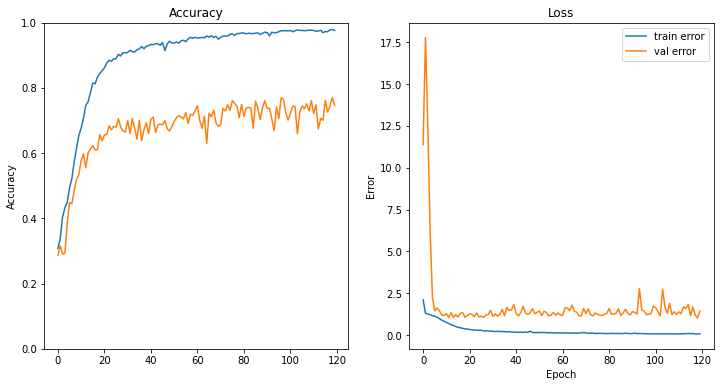

In [17]:
plot_history(history)

## Evaluation

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

84/84 - 3s - loss: 1.3326 - accuracy: 0.7533 - 3s/epoch - 34ms/step


In [19]:
if '.DS_Store' in os.listdir(dataset_path):
        os.remove(f'{dataset_path}/.DS_Store')

languages = os.listdir(dataset_path)

84/84 [==============================] - 3s 34ms/step


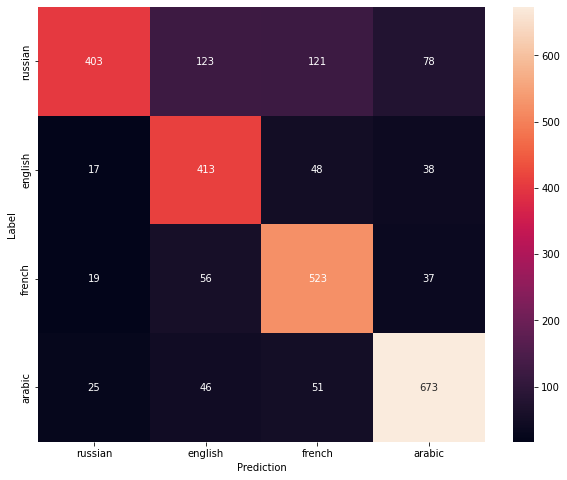

In [20]:
plot_confusion_matrix(model, X_test, languages)

# References:

Mikhailava, V.; Leshnichaia, M.; Bogach, N.; Lezhenin, I.; Blake, J.; Pyshkin, E. Language Accent Detection with CNN Using Sparse Data from a Crowd-Sourced Speech Archive. Mathematics 2022, 10, 2913. https://doi.org/10.3390/ math10162913 